In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
!nvidia-smi

Wed Jul 28 10:05:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [4]:
trainset = datasets.MNIST('train', download=True, train=True, transform=transform)
valset = datasets.MNIST('test', download=True, train=False, transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting train/MNIST/raw/train-images-idx3-ubyte.gz to train/MNIST/raw




Extracting train/MNIST/raw/train-labels-idx1-ubyte.gz to train/MNIST/raw




Extracting train/MNIST/raw/t10k-images-idx3-ubyte.gz to train/MNIST/raw




Extracting train/MNIST/raw/t10k-labels-idx1-ubyte.gz to train/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Extracting test/MNIST/raw/train-images-idx3-ubyte.gz to test/MNIST/raw




Extracting test/MNIST/raw/train-labels-idx1-ubyte.gz to test/MNIST/raw




Extracting test/MNIST/raw/t10k-images-idx3-ubyte.gz to test/MNIST/raw




Extracting test/MNIST/raw/t10k-labels-idx1-ubyte.gz to test/MNIST/raw



In [5]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [6]:
import random

In [7]:
td, vd = trainset, valset
indices = range(50000)
values = [(j, td[j][1]) for j in indices]

In [8]:
n=1000

In [9]:
indices_subset = [[v[0] for v in values if v[1] == j][:n]
                      for j in range(10)]

In [10]:
flattened_indices = [i for sub in indices_subset for i in sub]

In [11]:
td_prime = [(td[j][0], td[j][1]) for j in flattened_indices]

In [29]:
device='cuda'
td_prime = torch.load('/content/mnist25.pt')
valset = torch.load('/content/mnistval.pt')

In [30]:
trainloader = torch.utils.data.DataLoader(td_prime, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [31]:
# input_size = 784
# hidden_sizes = [128, 64]
# output_size = 10

# model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[0], hidden_sizes[1]),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[1], output_size),
#                       nn.LogSoftmax(dim=1))

In [32]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator,self).__init__()  
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0],hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1],output_size+1)
        self.relu = nn.LeakyReLU(negative_slope=0.2, inplace=False)
        self.activation = nn.Sigmoid()

    def forward(self,x):
        x = self.fc3(  self.relu(self.fc2(self.relu(self.fc1(x))))  )
        D_output = x[:,:-1]
        last_logit = self.activation(x[:,-1].reshape(1,-1))
        return D_output , last_logit


g_input_size = 100
g_hidden_sizes = [64, 128]
g_output_size = 784

class Generator(nn.Module):
    
    def __init__(self):
        super(Generator,self).__init__()  
        self.fc1 = nn.Linear(g_input_size, g_hidden_sizes[0])
        self.fc2 = nn.Linear(g_hidden_sizes[0],g_hidden_sizes[1])
        self.fc3 = nn.Linear(g_hidden_sizes[1],g_output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self , x):

        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)

        out = torch.tanh(self.fc3(x))
        return out

In [33]:
D = Discriminator().to(device)
G = Generator().to(device)

In [34]:
loss = nn.CrossEntropyLoss(reduction='mean')
loss1 = nn.BCELoss(reduction='mean')

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

Epoch 0 - Training loss: 0.5112200956791639
Epoch 1 - Training loss: 0.4024104196578264
Epoch 2 - Training loss: 0.23270500265061855
Epoch 3 - Training loss: 0.2085892278701067
Epoch 4 - Training loss: 0.24065210297703743
Epoch 5 - Training loss: 0.2230502162128687
Epoch 6 - Training loss: 0.29939563013613224
Epoch 7 - Training loss: 0.30477324314415455
Epoch 8 - Training loss: 0.3452939186245203
Epoch 9 - Training loss: 0.3445825055241585
Epoch 10 - Training loss: 0.4629910606890917
Epoch 11 - Training loss: 0.43661850318312645
Epoch 12 - Training loss: 0.3099810127168894
Epoch 13 - Training loss: 0.24091932456940413
Epoch 14 - Training loss: 0.3050506403669715
Epoch 15 - Training loss: 0.30681635718792677
Epoch 16 - Training loss: 0.3067819904536009
Epoch 17 - Training loss: 0.45219987258315086
Epoch 18 - Training loss: 0.46540068089962006
Epoch 19 - Training loss: 0.42684720642864704
Epoch 20 - Training loss: 0.2518908781930804


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch 21 - Training loss: 0.309665746986866
Epoch 22 - Training loss: 0.3049682695418596
Epoch 23 - Training loss: 0.36767708510160446
Epoch 24 - Training loss: 0.4207155369222164
Epoch 25 - Training loss: 0.38030390068888664
Epoch 26 - Training loss: 0.31019228883087635
Epoch 27 - Training loss: 0.39027848467230797
Epoch 28 - Training loss: 0.5951473191380501
Epoch 29 - Training loss: 0.5719594359397888
Epoch 30 - Training loss: 0.711237944662571
Epoch 31 - Training loss: 0.6991539411246777
Epoch 32 - Training loss: 0.35555409640073776
Epoch 33 - Training loss: 0.32698243483901024
Epoch 34 - Training loss: 0.5432784054428339
Epoch 35 - Training loss: 0.520564116537571
Epoch 36 - Training loss: 0.34764728508889675
Epoch 37 - Training loss: 0.2702220007777214
Epoch 38 - Training loss: 0.3131555840373039
Epoch 39 - Training loss: 0.5208943039178848
Epoch 40 - Training loss: 0.5522759221494198
Epoch 41 - Training loss: 0.56255161203444
Epoch 42 - Training loss: 0.39953191205859184
Epoch 4

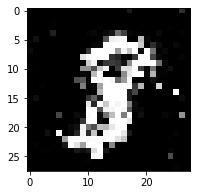

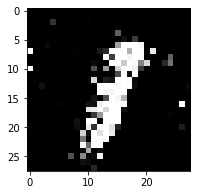

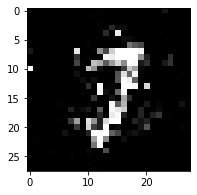

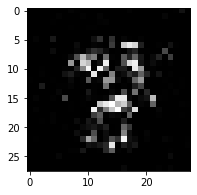

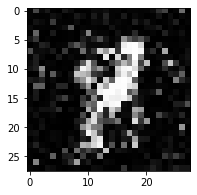

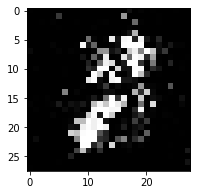

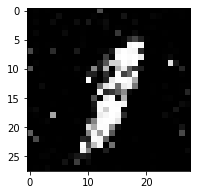

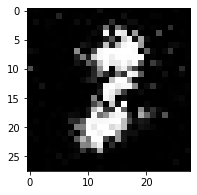

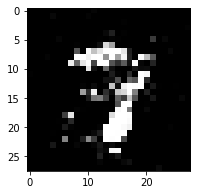

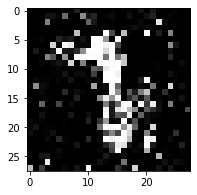

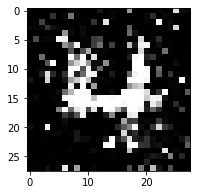

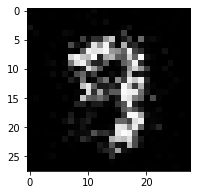

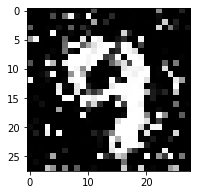

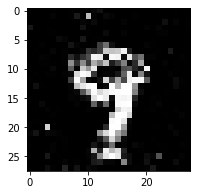

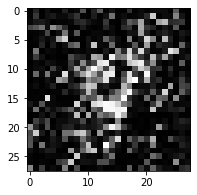

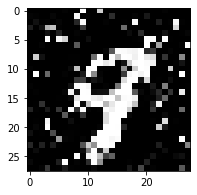

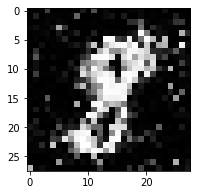

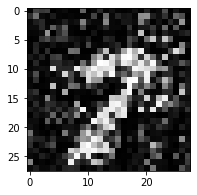

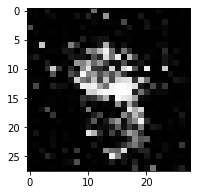

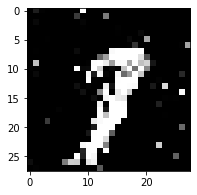

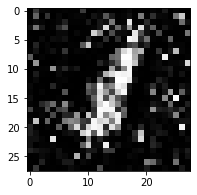

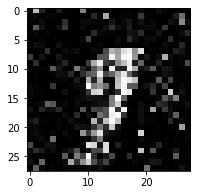

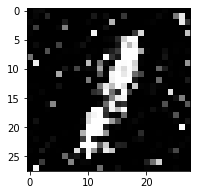

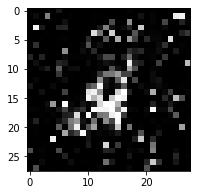

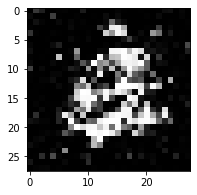

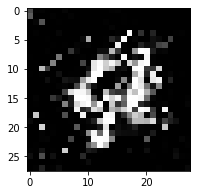

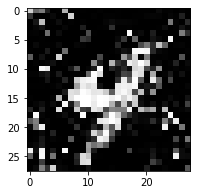

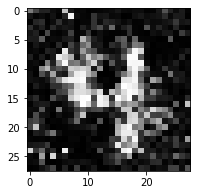

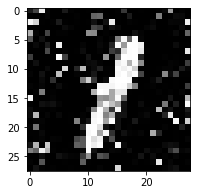

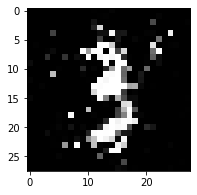

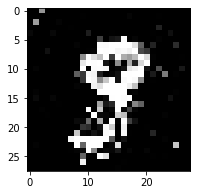

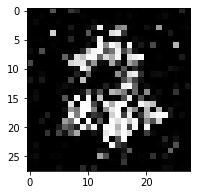

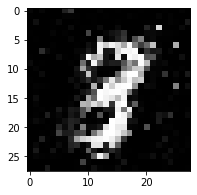

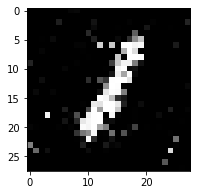

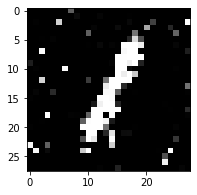

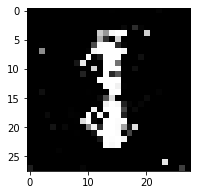

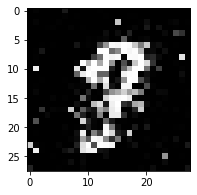

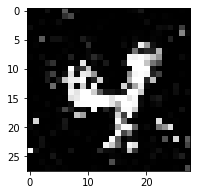

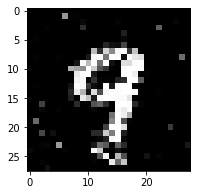

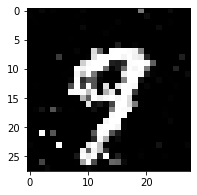

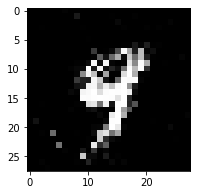

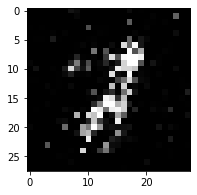

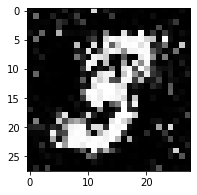

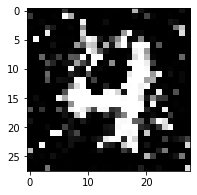

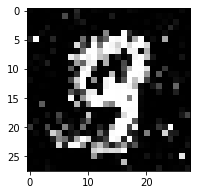

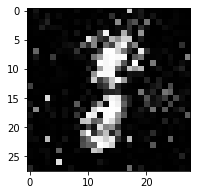

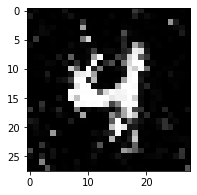

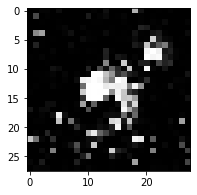

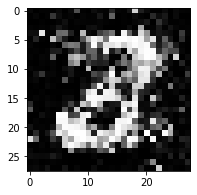

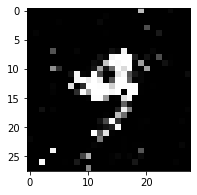

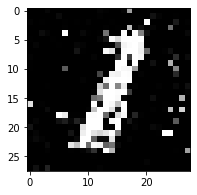

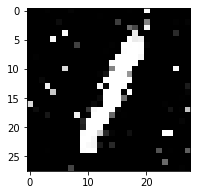

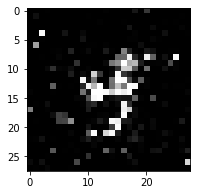

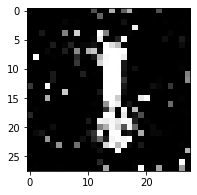

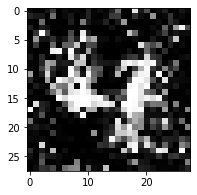

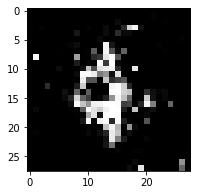

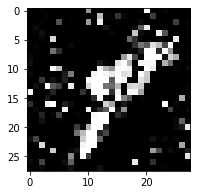

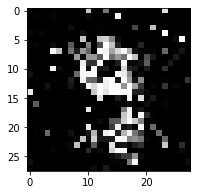

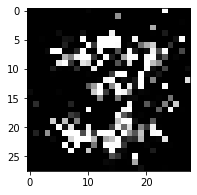

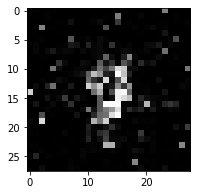

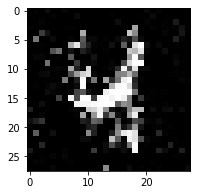

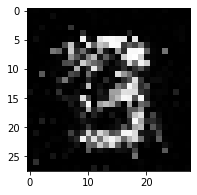

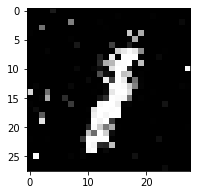

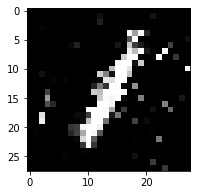

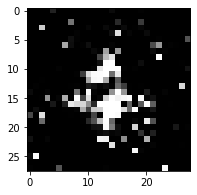

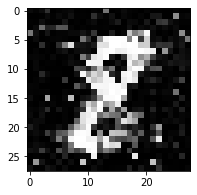

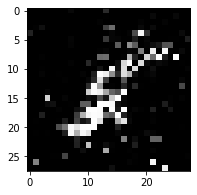

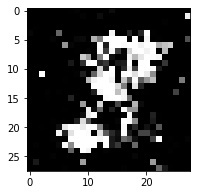

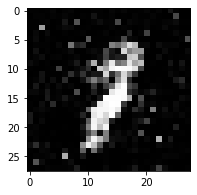

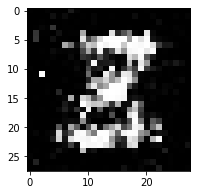

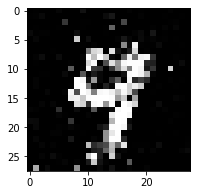

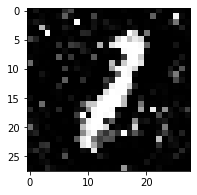

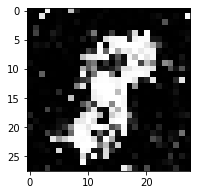

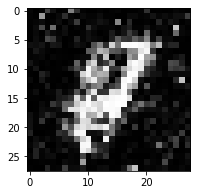

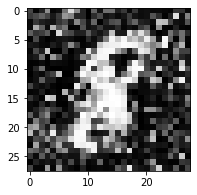

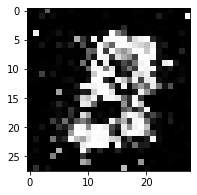

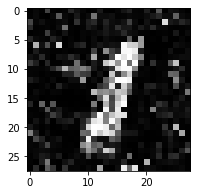

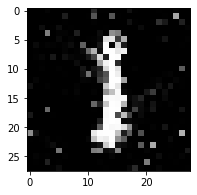

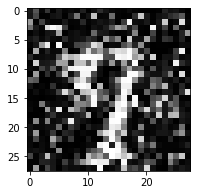

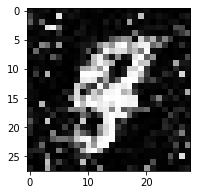

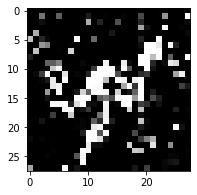

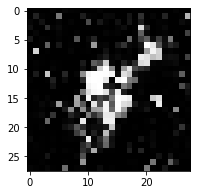

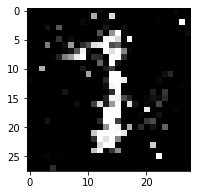

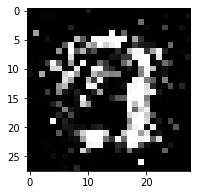

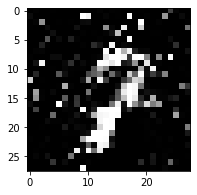

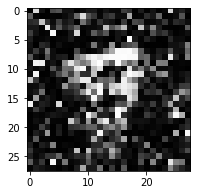

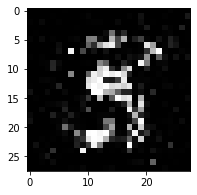

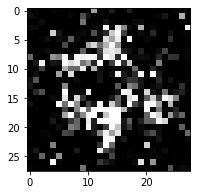

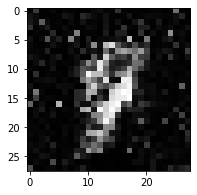

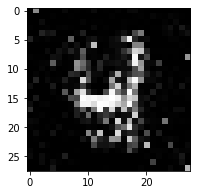

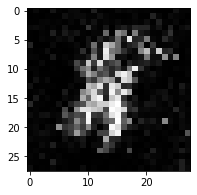

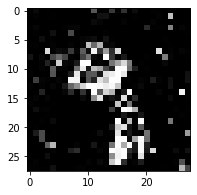

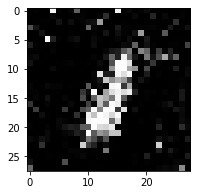

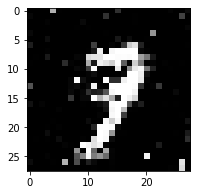

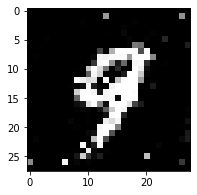

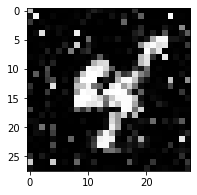

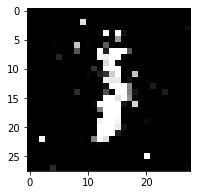

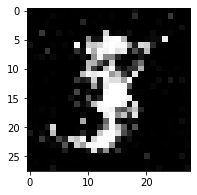

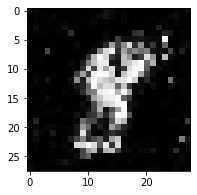

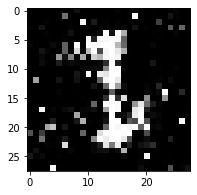

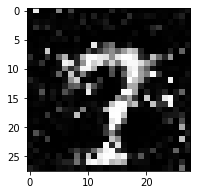

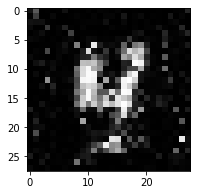

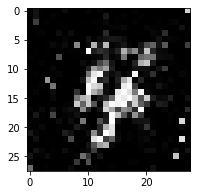

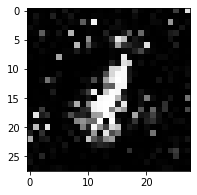

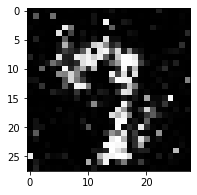

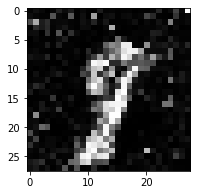

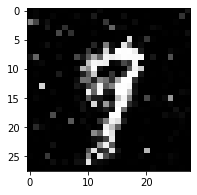

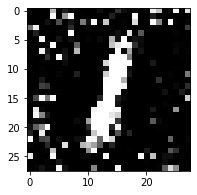

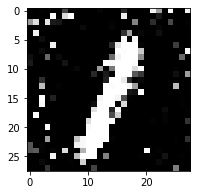

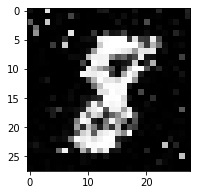

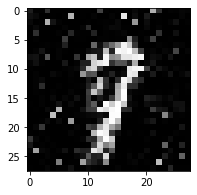

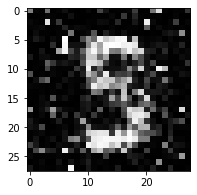

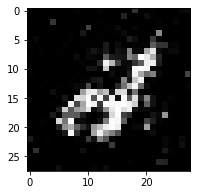

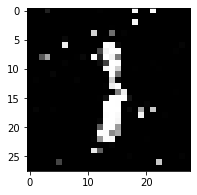

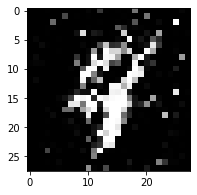

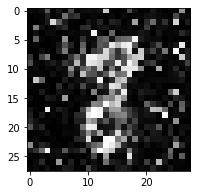

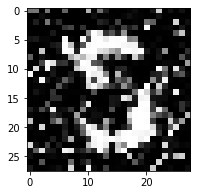

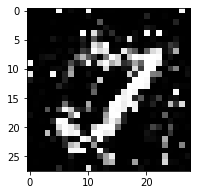

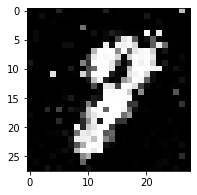

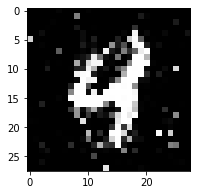

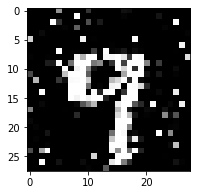

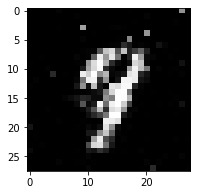

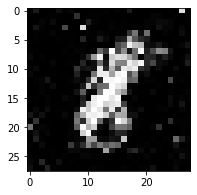

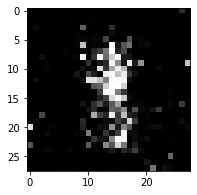

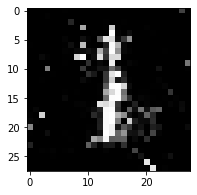

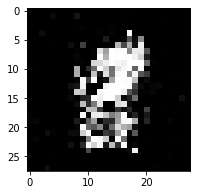

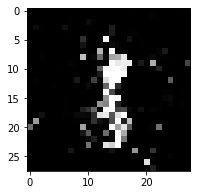

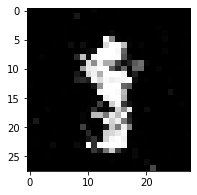

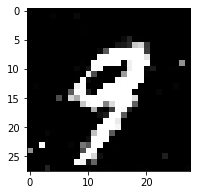

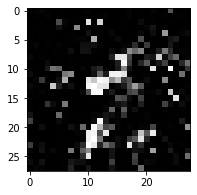

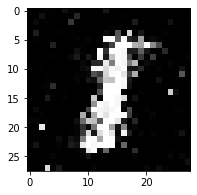

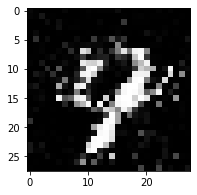

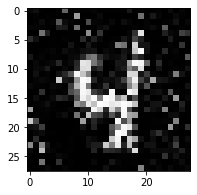

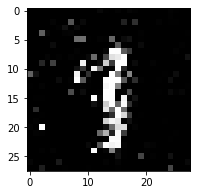

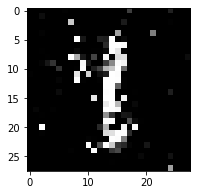

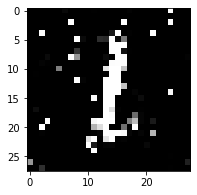

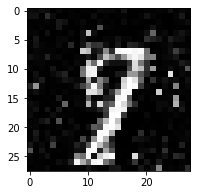

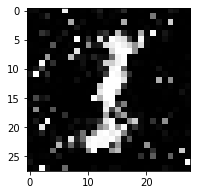

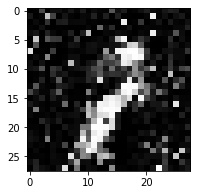

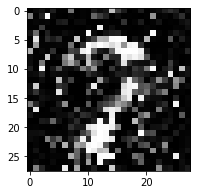

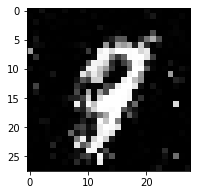

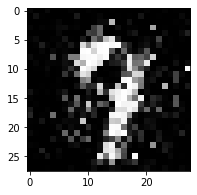

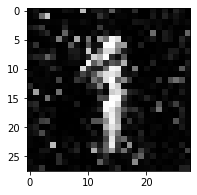

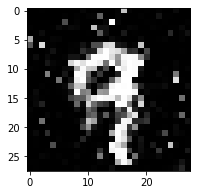

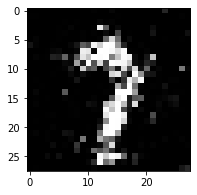

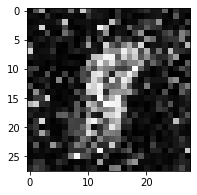

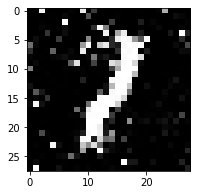

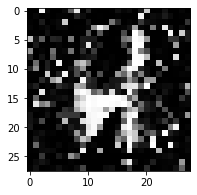

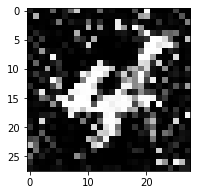

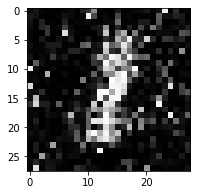

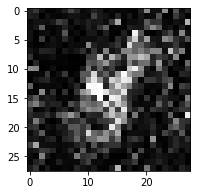

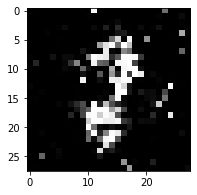

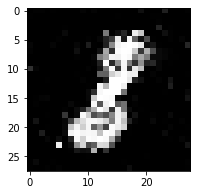

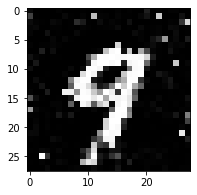

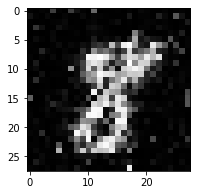

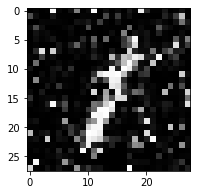

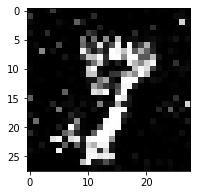

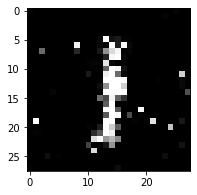

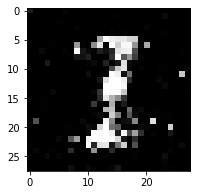

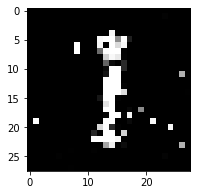

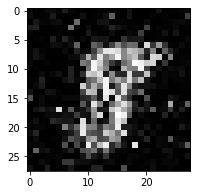

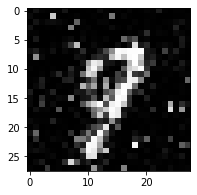

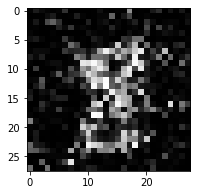

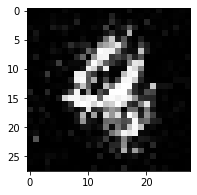

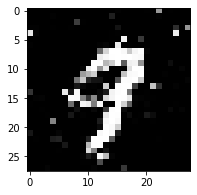

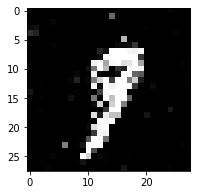

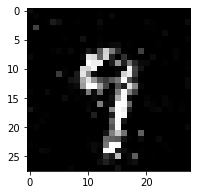

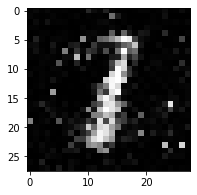

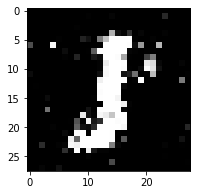

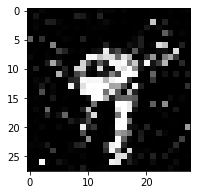

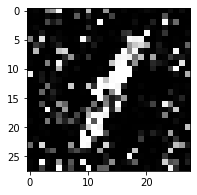

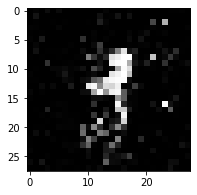

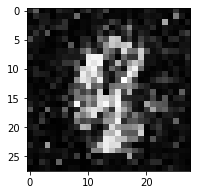

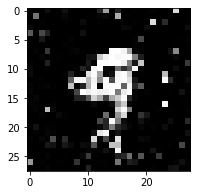

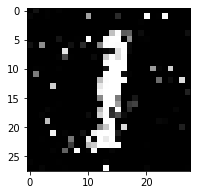

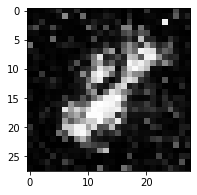

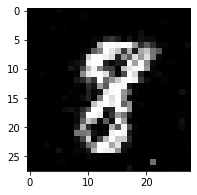

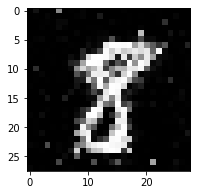

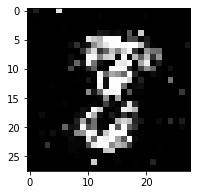

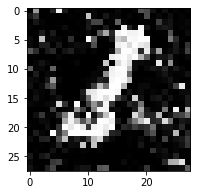

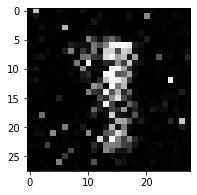

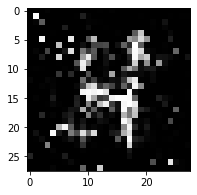

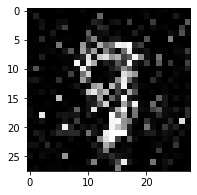

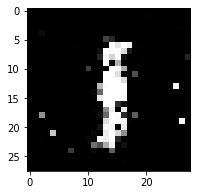

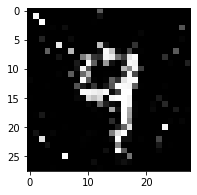

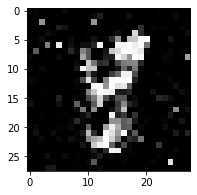

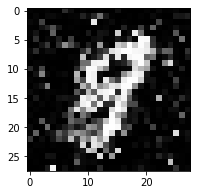

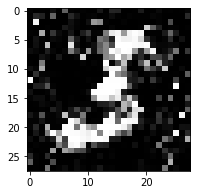

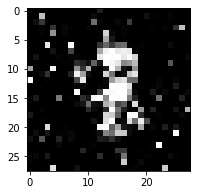

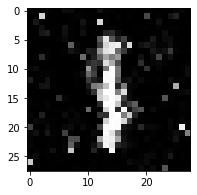

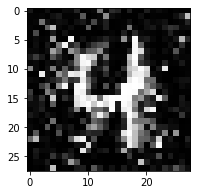

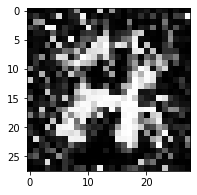

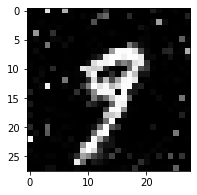

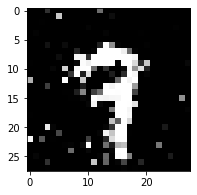

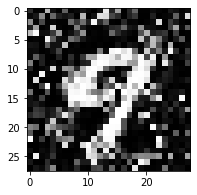

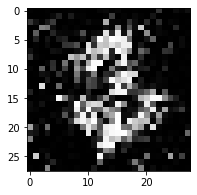

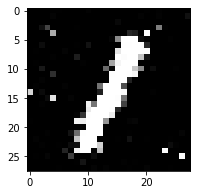

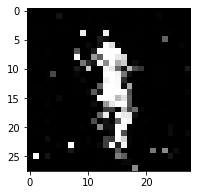

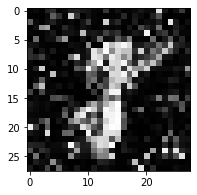

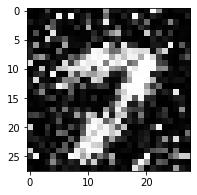

In [41]:
import torch.optim as optim
# Optimizers
lr = 0.002
train_ratio=1
# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)


time0 = time()
epochs = 200
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
      #train on fake images
        for i in range(train_ratio):
          z = np.random.uniform(-1, 1, size=(images.shape[0], g_input_size))
          z = torch.from_numpy(z).float().to(device)
          fake_images = G(z)
          # print(fake_images)
          # print(fake_images.shape)
          _ , last_logit = D(fake_images)


          G_label = torch.zeros((images.shape[0])).to(device)
          # print(last_logit.reshape(images.shape[0]))
          # print("label")
          # print(G_label)
          G_loss = loss1(last_logit.reshape(images.shape[0]) , G_label)

          # iitr
          # print(G_loss)
          # print(G_loss.shape)

          g_optimizer.zero_grad()

          G_loss.backward()
          g_optimizer.step()

          # print('yo')

        images = images.view(images.shape[0], -1)
        images = images.to(device)
        labels = labels.to(device)

        disc_logit , last_logit2 = D(images)
        task_train_error = loss(disc_logit.reshape(images.shape[0] , -1) , labels.reshape(images.shape[0]) )

        real_loss = loss1(last_logit2.reshape(images.shape[0]) , torch.zeros((images.shape[0])).to(device))

        # generator_2=Generator(32)
        # generator_2.load_state_dict(generator.state_dict())
        # generator_2=generator_2.to('cuda')
        z = np.random.uniform(-1, 1, size=(images.shape[0], g_input_size))
        z = torch.from_numpy(z).float().to(device)

        fake_data2 = G(z)
        _ , last_logit3 = D(fake_data2)
        
        G_label2 = torch.ones((images.shape[0])).to(device)
        fake_loss = loss1(last_logit3.reshape(images.shape[0]) , G_label2)

        train_error = task_train_error + (real_loss + fake_loss)
        # train_error = real_loss + fake_loss

        d_optimizer.zero_grad()

        train_error.backward()
        d_optimizer.step()

        running_loss += train_error.item()



    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        
        z = np.random.uniform(-1, 1, size=(1, g_input_size))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)

        fig = plt.figure(figsize = (3,3)) 
        plt.imshow(fake_images.detach().cpu().numpy().reshape(28,28),cmap='Greys_r')
        plt.savefig('G_out_{}'.format(e))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [9]:
!nvidia-smi

Tue Jul 27 09:36:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    58W / 149W |    459MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    img=img.to(device)
    with torch.no_grad():
        logits , _ = D(img)

    pred_label = torch.argmax(logits)
    
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.7782


In [9]:
z = np.random.uniform(-1, 1, size=(1, g_input_size))
z = torch.from_numpy(z).float().to(device)
fake_images = G(z)

In [10]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=2, ncols=2, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        # img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        # im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

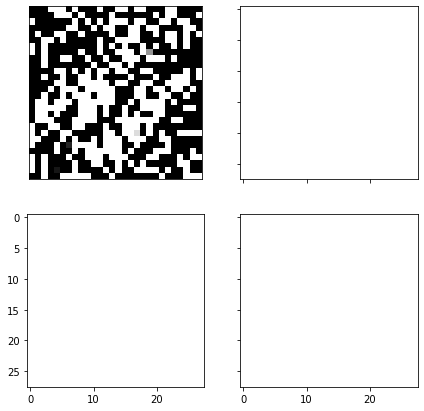

In [11]:
view_samples(0,[fake_images.detach().cpu().numpy()])

In [ ]:
torch.save(td_prime, 'mnist5.pt')

In [ ]:
torch.save(valset, 'mnistval.pt')